# Downloading Data

In this notebook we will download the necessary data and clean it.

## Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
from src.utils import get_xml_source, download_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)

### Downloading data

In [3]:
url = "https://www.cityobservatory.birmingham.gov.uk/@birmingham-city-council/purchase-card-transactions"
list_xml_urls = get_xml_source(url)
list_xls_local_paths = download_data(list_xml_urls, "../data/xls/") 

[0.83%] XLS file purchasecardtransactionsapril2014.xls already downloaded
[1.67%] XLS file purchasecardtransactionsmay2014.xls already downloaded
[2.50%] XLS file purchasecardtransactionsjune2014.xls already downloaded
[3.33%] XLS file purchasecardtransactionsjuly2014.xls already downloaded
[4.17%] XLS file purchasecardtransactionsaugust2014.xls already downloaded
[5.00%] XLS file purchasecardtransactionsseptember2014.xls already downloaded
[5.83%] XLS file purchasecardtransactionsoctober2014.xls already downloaded
[6.67%] XLS file purchasecardsnov2014.xls already downloaded
[7.50%] XLS file purchasecardsdec2014.xls already downloaded
[8.33%] XLS file purchaseccardtransactionsjanuary2015.xls already downloaded
[9.17%] XLS file publishspendpurchasecardsfebruary.xls already downloaded
[10.00%] XLS file publishspendpurchasecardsmarch.xls already downloaded
[10.83%] XLS file svlrdclr05homesharechexefinainmngeneralappublishspendmay2015.xls already downloaded
[11.67%] XLS file publishspendju

### Merging Data

In [4]:
# we load all the info into the ram memory to analyse it.

list_df = []
all_columns = []
for path in list_xls_local_paths:
    df = pd.read_excel(path)
    # we normalize the column names
    columns = df.columns.tolist()
    columns = [str(col).strip().replace(" ", "_").lower() for col in columns]
    df.columns = columns
    list_df.append(df)
    all_columns += columns

In [5]:
all_columns = list(set(all_columns)) # drop duplicates
all_columns = list(np.sort(all_columns)) # order

In [6]:
all_columns

['************8998',
 '0',
 '0.1',
 '2018-09-18_00:00:00',
 '75',
 '75.1',
 'a00',
 'adult_social_care_and_health',
 'billing_cur_code',
 'billing_cur_code.1',
 'billing_gross_amt',
 'card_number',
 'claim_name',
 'claim_no',
 'direcorate',
 'directorate',
 'directorates',
 'gbp',
 'gbp.1',
 'hmcourts-service.g',
 'mc70',
 'mcc_code',
 'mental_health_management_budget',
 'merchant_name',
 'merchant_tax_reg_no',
 'original_cur',
 'original_gross_amt',
 'rv3t0',
 'split_expense_category',
 'split_quantity',
 'split_unit_cost',
 'supplies_&_sev_mic',
 'trans_account_key',
 'trans_account_key_desc',
 'trans_cac_code_1',
 'trans_cac_code_10',
 'trans_cac_code_11',
 'trans_cac_code_12',
 'trans_cac_code_2',
 'trans_cac_code_3',
 'trans_cac_code_4',
 'trans_cac_code_5',
 'trans_cac_code_6',
 'trans_cac_code_7',
 'trans_cac_code_8',
 'trans_cac_code_9',
 'trans_cac_desc_1',
 'trans_cac_desc_10',
 'trans_cac_desc_11',
 'trans_cac_desc_12',
 'trans_cac_desc_2',
 'trans_cac_desc_3',
 'trans_cac_d

In [7]:
replacements = {
    "billing_cur_code": ["billing_cur_code.1"],
    "directorate" : ["direcorate", "directorates"]
}

list_df_ = []
for df in list_df:
    df.rename(columns={el:k for k,v in replacements.items() for el in v}, inplace=True)
    df = df.loc[:,~df.columns.duplicated()].copy()
    list_df_.append(df)

list_df = list_df_

In [8]:
# we determine what columns are present in each of the data sets

list_of_rows = []
list_errors = []
list_dates = []

for df, path in zip(list_df, list_xls_local_paths):
    try:
        columns = df.columns.tolist()
        dict_row = {}
        date_of_data = df["trans_date"].median()
        date_of_data_str = date_of_data.strftime('%Y-%m')
        dict_row["date"] = date_of_data_str
        
        for col in columns:
            dict_row[col] = 1
        
        list_of_rows.append(dict_row.copy())
        list_dates.append(date_of_data)
    except:
        list_errors.append(path)

df_summary_cols = pd.DataFrame(list_of_rows).fillna(0)
df_summary_cols.sort_values("date", inplace=True)
df_summary_cols["date"] = pd.to_datetime(df_summary_cols["date"])
df_summary_cols.set_index("date", inplace=True)

### How many columns are present in the data of the last n months?

In [9]:
list_num_valid_cols = []
n_months = -np.arange(len(df_summary_cols))

for n in n_months:
    df_last_n = df_summary_cols.iloc[n - 1:]
    num_valid_cols = (df_last_n.mean() == 1).sum()
    list_num_valid_cols.append(num_valid_cols)

list_num_valid_cols = np.array(list_num_valid_cols)
dates = df_summary_cols.index.to_list()
dates.reverse()

df_number_cols = pd.DataFrame({
    "number_of_cols" : list_num_valid_cols, 
    "date" : dates, 
    "months_before_last_info" : n_months
})

In [11]:
df_summary_cols.mean().sort_values(ascending=False).head(10)

trans_date            1.000000
card_number           1.000000
trans_cac_code_2      1.000000
trans_cac_code_1      1.000000
trans_cac_code_3      1.000000
original_gross_amt    1.000000
merchant_name         0.991597
directorate           0.991597
trans_cac_desc_2      0.798319
billing_cur_code      0.789916
dtype: float64

In [10]:
# we define minimum number of columns needed to be 16
# in this point we get the date threshold

min_cols = 17
mask = df_number_cols.number_of_cols >= min_cols
date_threshold = df_number_cols[mask]["date"].min()
date_threshold_str = date_threshold.strftime('%Y-%m')

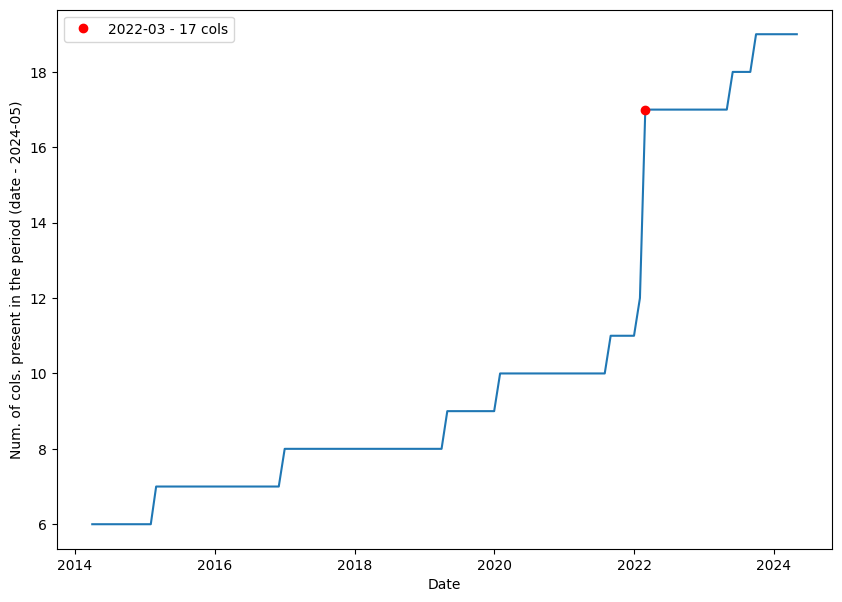

In [11]:
max_date = df_summary_cols.iloc[-1].name.strftime('%Y-%m')

fig, ax = plt.subplots()

ax.plot(df_number_cols.date, df_number_cols.number_of_cols)
ax.plot(date_threshold, min_cols, "ro", label=f"{date_threshold_str} - {min_cols} cols")
ax.set(
    xlabel=f"Date",
    ylabel=f"Num. of cols. present in the period (date - {max_date})"
)
ax.legend()

plt.show()

In [12]:
final_list_df = []

for date, df in zip(list_dates, list_df):
    if date >= date_threshold:
        final_list_df.append(df)

df_final = pd.concat(final_list_df)

In [13]:
final_cols = df_summary_cols[df_summary_cols.index >= date_threshold].mean()
final_cols = final_cols[final_cols == 1].index.tolist()

print(len(final_cols))

17


In [14]:
df_final = df_final[final_cols]
df_final.to_csv("../data/df.csv", index=False)